# Fake News Detection using Random Forest Classifier

### Objective:
Build a machine learning system that detects whether a news article is **Real or Fake**
using Natural Language Processing (NLP) techniques and a **Random Forest** classifier.

### Workflow Overview:
1. Import required libraries and dependencies
2. Load and merge real and fake news datasets
3. Preprocess the text:
   - Combine title, text, and subject
   - Clean text using regular expressions
   - Remove stopwords
   - Apply stemming
4. Convert the cleaned text into numerical features using **TF-IDF Vectorization**
5. Split data into training and testing sets (80/20 split, stratified)
6. Compare multiple models:
   - Logistic Regression
   - Multinomial Naive Bayes
   - Random Forest (chosen based on best performance)
7. Train the final model (Random Forest Classifier)
8. Evaluate model performance:
   - Accuracy, Precision, Recall, F1-score
   - Confusion Matrix (with visualization)
9. Enable custom input prediction system
10. Save the trained model and vectorizer using Pickle

### Problem Type:
- **Binary Classification**
  - `1` → Real News
  - `0` → Fake News

### Dataset:
- Files used: `WELFake_datset.csv`
- Columns: `title`, `text`, `subject`

---


# Step -1
### Importing Dependencies

In [ ]:
import numpy as np
import pandas as pd

import zipfile
# Used to extract and read files directly from ZIP archives

import re
# re (regular expression) library is useful for searching, replacing, or cleaning specific patterns in text.

from nltk.corpus import stopwords
# stopwords are common words (like a, the, is) that are usually removed from text data because they don’t add much meaning.

from nltk.stem.porter import PorterStemmer
# PorterStemmer helps reduce words to their base or root form. e.g., “playing”, “played” → “play”.

from sklearn.feature_extraction.text import TfidfVectorizer
# Converts text data into numerical format by calculating importance of words (TF-IDF technique).

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import pickle  # For saving the trained model and vectorizer

from tqdm.notebook import tqdm  # Progress bar for pandas apply

# Step - 2
### Downloading Stopwords

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# printing the stopwords
print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

# Step - 3
### Data collection

In [ ]:
news_data = pd.read_csv("/content/WELFake_Dataset.csv")

In [ ]:
# Print first few rows of the data
news_data.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [ ]:
# print the dimensions of our dataset (rows , columns)
news_data.shape

(72134, 4)

In [ ]:
# checking for missing values in dataset
news_data.isnull().sum()

,0
Unnamed: 0,0
title,558
text,39
label,0


In [ ]:
# Drop rows with missing title or text
news_data = news_data.dropna(subset=['title', 'text'])

In [ ]:
# Drop the 'Unnamed: 0' column
news_data = news_data.drop(columns=['Unnamed: 0'])

In [ ]:
# Reset index after dropping rows
news_data = news_data.reset_index(drop=True)

In [ ]:
# Count the number of real (1) and fake (0) news articles in the dataset
# This helps check for class balance before training
print(news_data['label'].value_counts())

label
1    36509
0    35028
Name: count, dtype: int64


In [ ]:
# Combine multiple useful columns into a single text feature
news_data['content'] = news_data['title'] + " " + news_data['text']

In [ ]:
news_data.head()

,title,text,label,content
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...
2,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri..."
3,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...
4,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,About Time! Christian Group Sues Amazon and SP...


# Step - 4
### Stemming
Stemming is the process of reducing a word to its root word.

- e.g:- "enjoyed" , "enjoyable" , "enjoying" ---> "enjoy"

In [ ]:
# Load stopwords once
stop_words = set(stopwords.words('english'))

In [ ]:
# load an instance of Porter Stemmer in a variable
port_stem = PorterStemmer()

This function cleans the text, removes stopwords, and applies stemming to reduce words to their root form.

In [ ]:
# create a function for stemming
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]', ' ', content)
    # Removes everything except letters (gets rid of numbers, punctuation, etc.)
    # ^ means exclude everthing else except ; [a-zA-Z] matches all letters; re.sub replaces non-letters in 'content' with spaces

    stemmed_content = stemmed_content.lower()
    # Converts all text to lowercase

    stemmed_content = stemmed_content.split()
    # Splits the sentence into individual words

    stemmed_content = [port_stem.stem(word)
                       for word in stemmed_content
                       if not word in stop_words]
    # Removes common stopwords and stems each word to its root form

    stemmed_content = " ".join(stemmed_content)
    # Joins the cleaned words back into a single string

    return stemmed_content
    # Returns the final preprocessed text

- `tqdm` is a Python library that shows a progress bar for loops — useful for long operations like text preprocessing.

- `tqdm.notebook` version is specifically designed for Jupyter/Colab notebooks with nice formatting.

- `tqdm.pandas()` integrates `tqdm` with pandas, so you can use `.progress_apply()` on DataFrame columns.

- `news_data['content'].progress_apply(stemming)` applies your custom `stemming()` function to every row in the `content` column, while showing live progress.

- This helps you track the progress of the stemming operation and estimate how long it will take to finish.

In [ ]:
tqdm.pandas()  # activate tqdm with pandas

news_data['content'] = news_data['content'].progress_apply(stemming)

  0%|          | 0/71537 [00:00<?, ?it/s]

In [ ]:
# printing the content column
print(news_data['content'])

0        law enforc high alert follow threat cop white ...
1        unbeliev obama attorney gener say charlott rio...
2        bobbi jindal rais hindu use stori christian co...
3        satan russia unv imag terrifi new supernuk wes...
4        time christian group sue amazon splc design ha...
                               ...                        
71532    russian steal research trump hack u democrat p...
71533    watch giuliani demand democrat apolog trump ra...
71534    migrant refus leav train refuge camp hungari m...
71535    trump tussl give unpopular mexican leader much...
71536    goldman sach endors hillari clinton presid gol...
Name: content, Length: 71537, dtype: object


# Step - 5
### TF-IDF Vectorization

**TF-IDF (Term Frequency-Inverse Document Frequency)** converts the raw text into numerical feature vectors, giving more importance to rare but meaningful words in the corpus.

- Initialize TF-IDF Vectorizer to convert text into numerical features
- Removes English stopwords (common words that add little meaning)
- Limits features to top 10000 most important words/ngrams
- Considers unigrams and bigrams (single words and pairs of words)

In [ ]:
vectorizer = TfidfVectorizer(
    stop_words='english',  # Removes common noise words
    max_features=10000,     # Prevents overfitting & keeps model lightweight
    ngram_range=(1, 2)     # Captures both single words AND pairs of words (context!)
)

In [ ]:
# Fit the vectorizer on the text and transform it into TF-IDF feature matrix
X_text = vectorizer.fit_transform(news_data['content'].values)

# Step - 6
### Feature and Target split

In [ ]:
# Features
X = X_text

In [ ]:
# Target
Y = news_data['label'].values

In [ ]:
print(X)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 13007627 stored elements and shape (71537, 10000)>
  Coords	Values
  (0, 4619)	0.019026424002667748
  (0, 2689)	0.027335394344346033
  (0, 3737)	0.022387317417255654
  (0, 214)	0.038504590288481265
  (0, 3158)	0.018510732101977574
  (0, 8842)	0.050179255545609196
  (0, 1767)	0.18409958062231668
  (0, 9753)	0.1807906231196575
  (0, 826)	0.10465148281291974
  (0, 8772)	0.054512705161496824
  (0, 9494)	0.0380227083720816
  (0, 1572)	0.020348404458152072
  (0, 2865)	0.021712101736532916
  (0, 639)	0.02439401653934254
  (0, 5773)	0.018468599345914934
  (0, 5154)	0.01919770340722972
  (0, 5423)	0.08382105548143161
  (0, 4905)	0.12004290333193536
  (0, 3612)	0.11207757868785721
  (0, 6154)	0.13082171769746395
  (0, 2671)	0.02982494039727032
  (0, 6787)	0.18569012478721098
  (0, 9227)	0.02154012421639555
  (0, 5670)	0.02384010518562359
  (0, 9244)	0.10297184223483512
  :	:
  (71536, 7588)	0.029821784812658438
  (71536, 748)	0.031387

In [ ]:
print(Y)

[1 1 0 ... 0 0 1]


# Step - 7
### Train Test Split

- Splitting data into training and testing sets
- 80% training data, 20% testing data
- Stratify to keep label distribution consistent in both sets

In [ ]:
X_train , X_test , Y_train , Y_test = train_test_split(
    X , Y , test_size= 0.2 , random_state=2 , stratify= Y)

# Step - 8
### Model Comparison

In [ ]:
# Create a list of models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Iterate through the list to get predictions from each model
for name, model in models.items():
    model.fit(X_train, Y_train)   # Fit the model
    preds = model.predict(X_test)

    # Print the Performance of each model
    print(f"\n{name} Performance ")
    print("Accuracy:", accuracy_score(Y_test, preds))
    print("Classification Report:\n", classification_report(Y_test, preds))
    print("-------------------------------------------------------")


Logistic Regression Performance 
Accuracy: 0.946393625943528
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94      7006
           1       0.94      0.95      0.95      7302

    accuracy                           0.95     14308
   macro avg       0.95      0.95      0.95     14308
weighted avg       0.95      0.95      0.95     14308

-------------------------------------------------------

Naive Bayes Performance 
Accuracy: 0.8622448979591837
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.84      0.86      7006
           1       0.85      0.89      0.87      7302

    accuracy                           0.86     14308
   macro avg       0.86      0.86      0.86     14308
weighted avg       0.86      0.86      0.86     14308

-------------------------------------------------------

Random Forest Performance 
Accuracy: 0.9556891249650545
Classificati

- Random Forest achieved the highest accuracy (~95.6%) and showed balanced precision, recall, and F1-score.

- Logistic Regression also performed well (~94.6%) but slightly below Random Forest.

- Naive Bayes showed lower accuracy (~86.2%) and is less suitable for this task.

# Step - 9
### Model Training
Initialize and train the Random Forest model

In [ ]:
model = LogisticRegression()

In [ ]:
# Fit the model on the training data
model.fit(X_train, Y_train)

LogisticRegression()

# Step - 10
### Model Evaluation


In [ ]:
# Predict on training data
X_train_pred = model.predict(X_train)

In [ ]:
# Evaluation Metrics
training_data_accuracy = accuracy_score( Y_train , X_train_pred)
report = classification_report(Y_train, X_train_pred)
conf_matrix = confusion_matrix(Y_train, X_train_pred)

In [ ]:
print(f"Training Data Accuracy is : {training_data_accuracy}")
print(f"Classification Report is : {report}")
print(f"Confusion Matrix is : {conf_matrix}")

Training Data Accuracy is : 0.9586049031085638
Classification Report is :               precision    recall  f1-score   support

           0       0.96      0.95      0.96     28022
           1       0.95      0.96      0.96     29207

    accuracy                           0.96     57229
   macro avg       0.96      0.96      0.96     57229
weighted avg       0.96      0.96      0.96     57229

Confusion Matrix is : [[26692  1330]
 [ 1039 28168]]


In [ ]:
# Predict on test data
X_test_pred = model.predict(X_test)

In [ ]:
# Evaluation Metrics
test_data_accuracy = accuracy_score( Y_test , X_test_pred)
report_test = classification_report(Y_test, X_test_pred)
conf_matrix_test = confusion_matrix(Y_test, X_test_pred)

In [ ]:
print(f"Test Data Accuracy is : {test_data_accuracy}")
print(f"Classification Report is : {report_test}")
print(f"Confusion Matrix is : {conf_matrix_test}")

Test Data Accuracy is : 0.946393625943528
Classification Report is :               precision    recall  f1-score   support

           0       0.95      0.94      0.94      7006
           1       0.94      0.95      0.95      7302

    accuracy                           0.95     14308
   macro avg       0.95      0.95      0.95     14308
weighted avg       0.95      0.95      0.95     14308

Confusion Matrix is : [[6583  423]
 [ 344 6958]]


# Step - 11
### Visualization - Confusion Matrix

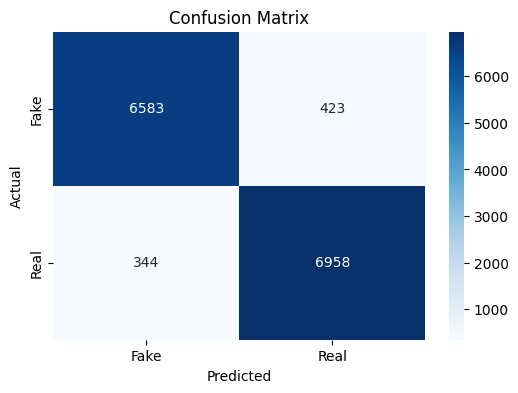

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_test , annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step - 12
### Making a Custom Input System

In [ ]:
def predict_custom_news(news_text, vectorizer, model):
    # Preprocess the input using the same stemming function
    stemmed_text = stemming(news_text)
    vectorized_text = vectorizer.transform([stemmed_text])
    prediction = model.predict(vectorized_text)
    return "Real" if prediction[0] == 1 else "Fake"

### Example usage:

In [ ]:
sample_news = "Breaking: President gives major update on national policy."
result = predict_custom_news(sample_news, vectorizer, model)
print(f"\nPrediction for custom news input: {result}")


Prediction for custom news input: Real


# Step - 13
### Save the model and vectorizer using pickle


In [ ]:
with open("logistic_regression_model.pkl", "wb") as model_file:
    pickle.dump(model, model_file)

with open("tfidf_vectorizer.pkl", "wb") as vec_file:
    pickle.dump(vectorizer, vec_file)